# Anomaly Detection Project
By Jeff Akins

### ![](https://mk0crunchmetric1ct0g.kinstacdn.com/wp-content/uploads/2019/10/Anomaly-detection-on-time-series-data-with-auto-encoders.jpg)

#### Imports:

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
import prepare as prep

#### Data is prepped in the prepare.py file and retrived in the next line:

In [2]:
log = prep.prep_logs()

#### Initial Data Exploration:

In [3]:
log.head()

,path,user_id,cohort_id,ip,name,slack,start_date,end_date,created_at,updated_at,program_id,course_name,course_subdomain,hour,weekday
timestamp,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,Java Full Stack Web Dev,java,9,Friday


In [4]:
log.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   path              900222 non-null  object        
 1   user_id           900223 non-null  int64         
 2   cohort_id         900223 non-null  int64         
 3   ip                900223 non-null  object        
 4   name              900223 non-null  object        
 5   slack             900223 non-null  object        
 6   start_date        900223 non-null  datetime64[ns]
 7   end_date          900223 non-null  datetime64[ns]
 8   created_at        900223 non-null  datetime64[ns]
 9   updated_at        900223 non-null  datetime64[ns]
 10  program_id        900223 non-null  int64         
 11  course_name       900223 non-null  object        
 12  course_subdomain  900223 non-null  object        
 13  hour              900223 

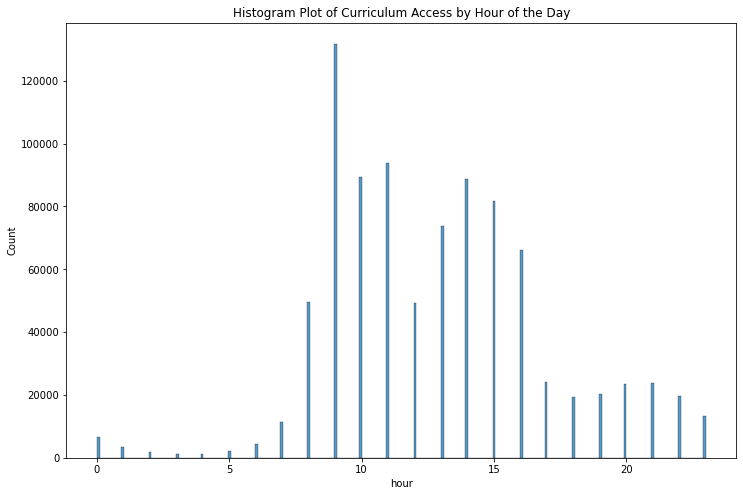

In [5]:
# Histogram Plot of Curriculum Access by Hour of the Day
plt.figure(figsize=(12, 8))
sns.histplot(data=log,
    x="hour", palette="ch:s=.25,rot=-.25",)
plt.title('Histogram Plot of Curriculum Access by Hour of the Day')
plt.show()

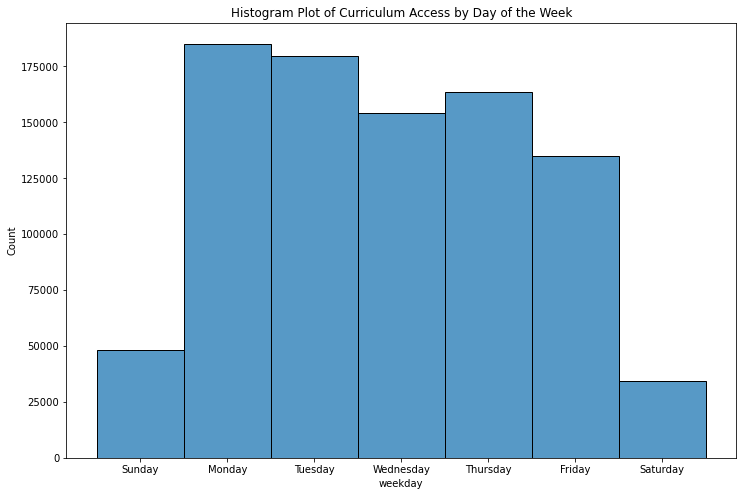

In [6]:
# Histogram Plot of Curriculum Access by Day of the Week
plt.figure(figsize=(12, 8))
sns.histplot(data=log,
    x="weekday", palette="ch:s=.25,rot=-.25",)
plt.title('Histogram Plot of Curriculum Access by Day of the Week')
plt.show()

## Questions

### 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [7]:
log.head(2)

,path,user_id,cohort_id,ip,name,slack,start_date,end_date,created_at,updated_at,program_id,course_name,course_subdomain,hour,weekday
timestamp,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday


In [8]:
# Removing all paths that are not a lesson
lesson = log.copy()
lesson = lesson[lesson.path.str.endswith('jpg') == False]
lesson = lesson[lesson.path.str.endswith('jpeg') == False]
lesson = lesson[lesson.path.str.endswith('svg') == False]
lesson = lesson[(lesson.path != '/') & (lesson.path != 'search/search_index.json') 
                & (lesson.path != 'toc') & (lesson.path != 'appendix')]

In [12]:
# List of top 20 lessons across all cohorts:
top_lessons = pd.DataFrame(lesson.path.value_counts().head(20))
top_lessons

,path
javascript-i,18983
java-iii,13733
html-css,13635
java-ii,12685
spring,12524
jquery,11525
mysql,11033
java-i,10865
javascript-ii,10730
javascript-i/introduction/working-with-data-types-operators-and-variables,7642


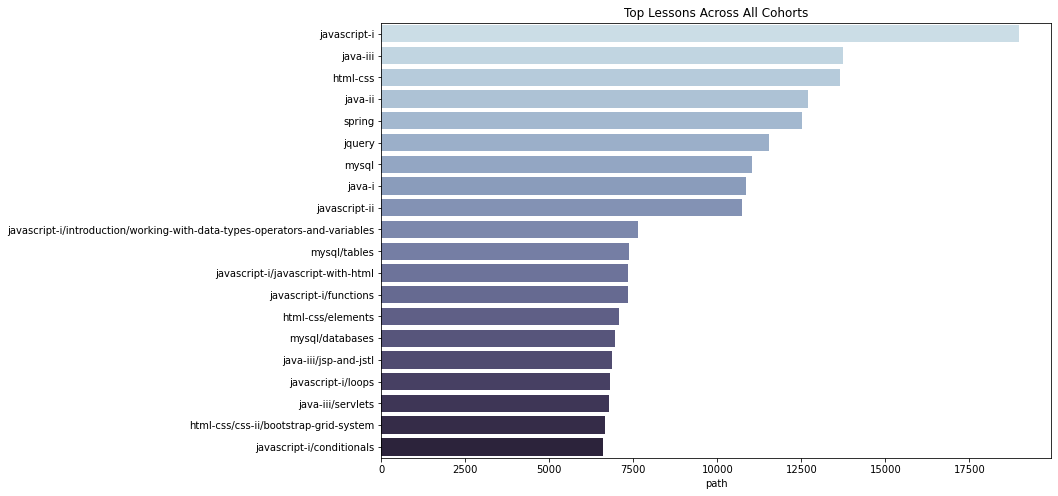

In [11]:
# Plot of top 20 lessons across all cohorts:
plt.figure(figsize=(12, 8))
sns.barplot(data=top_lessons,
    x="path", y=top_lessons.index, palette="ch:s=.25,rot=-.25", )
plt.title('Top Lessons Across All Cohorts')
plt.show()

##### Top Five Lessons for Each Cohort

In [22]:
cohort_names = lesson.name.unique()
cohort_names

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', 'none', 'Kings', 'Lassen', 'Mammoth', 'Glacier',
       'Denali', 'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo',
       'Ike', 'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite',
       'Staff', 'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes',
       'Deimos', 'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Florence', 'Neptune', 'Oberon'], dtype=object)

In [30]:
cohort_names.shape

(47,)

ValueError: too many values to unpack (expected 3)

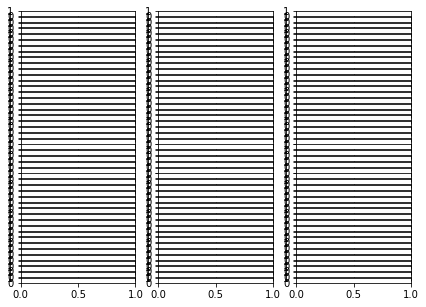

In [35]:
cohort_names = lesson.name.unique()
for cohort_name in cohort_names:
    top_cohort_lessons = pd.DataFrame(lesson[lesson.name == cohort_name].path.value_counts().head(5))

    grid = sns.FacetGrid(df, col="walk", hue="walk", palette="tab20c",
                     col_wrap=4, height=1.5)
    

    
    

In [ ]:
    f, (ax1, ax2, ax3) = plt.subplots(47, 3, figsize=(7, 5), sharex=True)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_cohort_lessons,
    x="path", y=top_lessons.index, palette="ch:s=.25,rot=-.25", )
    plt.title('Top Lessons for {cohort_name}')
    plt.show()

In [25]:
top_cohort_lessons = pd.DataFrame(lesson[lesson.name == 'Easley'].path.value_counts().head(5))
top_cohort_lessons

,path
classification/overview,445
fundamentals/intro-to-data-science,372
sql/mysql-overview,295
regression/model,204
stats/compare-means,202
